In [0]:
!pip install --upgrade tensorflow

In [1]:
!pip install -q tensorflow tensorflow-datasets matplotlib
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import os
import cv2
import random
from google.colab import files
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
print("TF version: ",tf.__version__)
print("Keras version:",tf.keras.__version__)
#import necessary packages

TF version:  2.0.0
Keras version: 2.2.4-tf


Using TensorFlow backend.


In [3]:
uploaded = files.upload()

Saving fer2013.csv to fer2013.csv


In [0]:
data = pd.read_csv('fer2013.csv')

In [0]:
data.values

In [0]:
def decodeY(y):
    if y==0:
        return 'Angry'
    elif y==1:
        return 'Disgust'
    elif y==2:
        return 'Fear'
    elif y==3:
        return 'Happy'
    elif y==4:
        return 'Sad'
    elif y==5:
        return 'Surprise'
    else:
        return 'Neutral'
#Decode 0-6 to 7 different emotions

In [0]:
def createData(data, test_size):
    data = data.values
    y = data[:, 0]
    pixels = data[:, 1]
    
    data_discarded = 0
    X = []
    Y = []
    count = 0
    for ix in range(pixels.shape[0]):
            if count%1000 == 0:
                print("[INFO] {} images loaded".format(count))
            temp = np.zeros((48*48))
            p = pixels[ix].split(' ')
            if len(pixels[ix].split(' '))>=2304:
              for iy in range(temp.shape[0]):
                   temp[iy] = int(p[iy])
              X.append(temp)
              Y.append(y[ix])
              count+=1
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, shuffle=True)  
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    print("[INFO] Done")
    
    return np.array(X_train), np.array(X_test), y_train, y_test
#Generate images based on image pixels

In [0]:
X_train, X_test, y_train, y_test = createData(data, 0.2)
#Separate training and testing sets

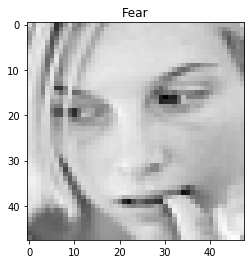

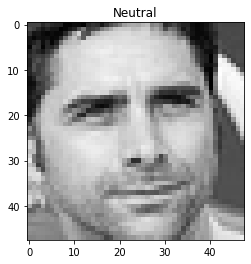

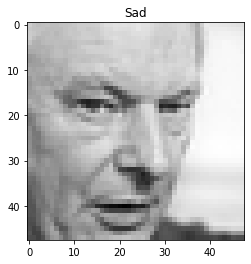

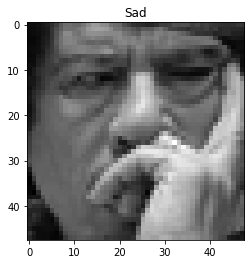

In [21]:
def showImage(X, y):
    for ix in range(4):
        plt.figure(ix)
        plt.title(decodeY(np.argmax(y[ix])))
        plt.imshow(X[ix].reshape((48, 48)), interpolation='none', cmap='gray')
    plt.show()
showImage(X_train, y_train)
#Plot the images 

In [0]:
X_train = X_train.reshape((X_train.shape[0], 48, 48, 1))
X_test = X_test.reshape((X_test.shape[0], 48, 48, 1))
#Reshape X_train and X_test

In [0]:
image_size = 48
image_channel = 1
input_shape = (image_size, image_size, image_channel)
mobilenet_transfer = tf.keras.Sequential([
     tf.keras.layers.Conv2D(32, kernel_size = (3, 3), padding = 'same', 
     activation = 'relu', input_shape = input_shape, name = 'conv_1'),  
     tf.keras.layers.MaxPooling2D(pool_size = (2, 2), name = 'pooling_1'),

     tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = 'same', 
     activation = 'relu', name = 'conv_2'),
     tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = 'same', 
     activation = 'relu', name = 'conv_3'),     
     tf.keras.layers.MaxPooling2D(pool_size = (2, 2), name = 'pooling_2'),

     tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = 'same', 
     activation = 'relu', name = 'conv_4'),
     tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = 'same', 
     activation = 'relu', name = 'conv_5'),
     tf.keras.layers.MaxPooling2D(pool_size = (2, 2), name = 'pooling_3'),

     tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = 'same', 
     activation = 'relu', name = 'conv_6'), 
     tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = 'same', 
     activation = 'relu', name = 'conv_7'),
     tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = 'same', 
     activation = 'relu', name = 'conv_8'),    
     tf.keras.layers.MaxPooling2D(pool_size = (2, 2), name = 'pooling_4'),

     tf.keras.layers.Dropout(0.5),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation = 'relu', name = 'fully_connected_1'),
     tf.keras.layers.Dense(7, activation = 'softmax', name = 'fully_connected_2')
                                      ])
mobilenet_transfer.summary()
#Construct Convolutional Neural Networks Model

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
pooling_1 (MaxPooling2D)     (None, 24, 24, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 24, 24, 64)        18496     
_________________________________________________________________
conv_3 (Conv2D)              (None, 24, 24, 64)        36928     
_________________________________________________________________
pooling_2 (MaxPooling2D)     (None, 12, 12, 64)        0         
_________________________________________________________________
conv_4 (Conv2D)              (None, 12, 12, 64)        36928     
_________________________________________________________________
conv_5 (Conv2D)              (None, 12, 12, 64)      

In [0]:
mobilenet_transfer.compile(optimizer = 'adam',
                       loss = 'categorical_crossentropy',
                       metrics = ['accuracy'])
#Specify loss and optimizer

In [0]:
model_fitted = mobilenet_transfer.fit(
   X_train,
   y_train,
   epochs = 10,
   batch_size = 32, 
   validation_data = (X_test, y_test))
#Train the model with batch size 32 and 10 epochs

Train on 28709 samples, validate on 7178 samples
Epoch 1/10
28709/28709 [==============================] - 366s 13ms/sample - loss: 1.7208 - accuracy: 0.3068 - val_loss: 1.5130 - val_accuracy: 0.4125
Epoch 2/10
28709/28709 [==============================] - 364s 13ms/sample - loss: 1.4801 - accuracy: 0.4222 - val_loss: 1.4000 - val_accuracy: 0.4621
Epoch 3/10
28709/28709 [==============================] - 364s 13ms/sample - loss: 1.3678 - accuracy: 0.4699 - val_loss: 1.3151 - val_accuracy: 0.4908
Epoch 4/10
28709/28709 [==============================] - 364s 13ms/sample - loss: 1.2900 - accuracy: 0.5015 - val_loss: 1.2876 - val_accuracy: 0.5011
Epoch 5/10
28709/28709 [==============================] - 364s 13ms/sample - loss: 1.2496 - accuracy: 0.5179 - val_loss: 1.2972 - val_accuracy: 0.5114
Epoch 6/10
28709/28709 [==============================] - 369s 13ms/sample - loss: 1.2024 - accuracy: 0.5399 - val_loss: 1.2452 - val_accuracy: 0.5217
Epoch 7/10
28709/28709 [=====================

The loss decreases from 1.7208 to 1.0898 as well as validation loss decreases from 1.5130 to 1.2041. Both training and validation accuracy increase a significant amount. After 10 epochs, the training accuracy is 0.5849 and validation accuracy 0.5408 which overfitting is not a concern.

Text(0, 0.5, 'Accuracy')

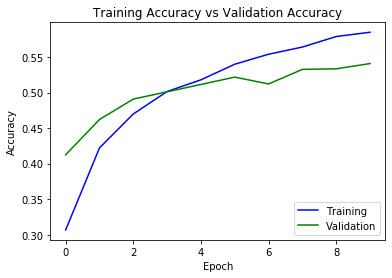

In [0]:
plt.plot(model_fitted.history['accuracy'], "-b", label = "Training")
plt.plot(model_fitted.history['val_accuracy'], "-g", label = "Validation")
plt.legend(loc = 'lower right')
plt.title('Training Accuracy vs Validation Accuracy', loc = 'center')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#Plot training accuracy vs validation accuracy

In [0]:
def createData_three_channels(data, test_size):
    data = data.values
    y = data[:, 0]
    pixels = data[:, 1]
    data_discarded = 0
    X = []
    Y = []
    count = 0
    for ix in range(pixels.shape[0]):
            if count%1000 == 0:
                print("[INFO] {} images loaded".format(count))
            temp = np.zeros((48*48))
            p = pixels[ix].split(' ')
            if len(pixels[ix].split(' '))>=2304:
              for iy in range(temp.shape[0]):
                   temp[iy] = int(p[iy])
              X.append(temp)
              Y.append(y[ix])
              count+=1
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, shuffle=True)  
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    X_train_3 = np.stack((X_train,)*3, axis=-1)
    X_test_3 = np.stack((X_test,)*3, axis=-1)

    print("[INFO] Done")
    return np.array(X_train_3), np.array(X_test_3), y_train, y_test
#Modify the function from single channel into three channels

In [9]:
X_train_3, X_test_3, y_train, y_test = createData_three_channels(data, 0.2)
#Load the images as well as split the training and testing sets

[INFO] 0 images loaded
[INFO] 1000 images loaded
[INFO] 2000 images loaded
[INFO] 3000 images loaded
[INFO] 4000 images loaded
[INFO] 5000 images loaded
[INFO] 6000 images loaded
[INFO] 7000 images loaded
[INFO] 8000 images loaded
[INFO] 9000 images loaded
[INFO] 10000 images loaded
[INFO] 11000 images loaded
[INFO] 12000 images loaded
[INFO] 13000 images loaded
[INFO] 14000 images loaded
[INFO] 15000 images loaded
[INFO] 16000 images loaded
[INFO] 17000 images loaded
[INFO] 18000 images loaded
[INFO] 19000 images loaded
[INFO] 20000 images loaded
[INFO] 21000 images loaded
[INFO] 22000 images loaded
[INFO] 23000 images loaded
[INFO] 24000 images loaded
[INFO] 25000 images loaded
[INFO] 26000 images loaded
[INFO] 27000 images loaded
[INFO] 28000 images loaded
[INFO] 29000 images loaded
[INFO] 30000 images loaded
[INFO] 31000 images loaded
[INFO] 32000 images loaded
[INFO] 33000 images loaded
[INFO] 34000 images loaded
[INFO] 35000 images loaded
[INFO] Done


In [0]:
X_train_3 = X_train_3.reshape((X_train_3.shape[0], 48, 48, 3))
X_test_3 = X_test_3.reshape((X_test_3.shape[0], 48, 48, 3))
#Reshape the images into three channels

In [0]:
MobileNet = tf.keras.applications.MobileNetV2(input_shape = (48, 48, 3), include_top = False, weights = 'imagenet')
#Load MobileNet 

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [0]:
model_fitted_mobilenet = tf.keras.Sequential([
     MobileNet,
     tf.keras.layers.Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = 'same', name = 'conv_ex1'),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(1024, activation = 'relu', name = 'fully_connected_1'),
     tf.keras.layers.Dense(1024, activation = 'relu', name = 'fully_connected_2'),
     tf.keras.layers.Dense(512, activation = 'relu', name = 'fully_connected_3'),
     tf.keras.layers.Dense(7, activation = 'softmax', name = 'fully_connected_4')
                                      ])
model_fitted_mobilenet.summary()
#Construct model based on MobileNet transfer learning

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 2, 2, 1280)        2257984   
_________________________________________________________________
conv_ex1 (Conv2D)            (None, 2, 2, 128)         1474688   
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
fully_connected_1 (Dense)    (None, 1024)              525312    
_________________________________________________________________
fully_connected_2 (Dense)    (None, 1024)              1049600   
_________________________________________________________________
fully_connected_3 (Dense)    (None, 512)               524800    
_________________________________________________________________
fully_connected_4 (Dense)    (None, 7)                

In [0]:
model_fitted_mobilenet.compile(optimizer = 'adam',
                       loss = 'categorical_crossentropy',
                       metrics = ['accuracy'])
#Specify loss and optimizer

In [0]:
model_fitted_1 = model_fitted_mobilenet.fit(
   X_train_3,
   y_train,
   epochs = 10,
   batch_size = 32, 
   validation_data = (X_test_3, y_test))
#Train the model with 10 epochs and batch size 32

Train on 28709 samples, validate on 7178 samples
Epoch 1/10
28709/28709 [==============================] - 913s 32ms/sample - loss: 1.6037 - accuracy: 0.3632 - val_loss: 1.8413 - val_accuracy: 0.1686
Epoch 2/10
28709/28709 [==============================] - 904s 32ms/sample - loss: 1.5381 - accuracy: 0.3853 - val_loss: 2.1594 - val_accuracy: 0.1567
Epoch 3/10
28709/28709 [==============================] - 906s 32ms/sample - loss: 1.4996 - accuracy: 0.4046 - val_loss: 1.9526 - val_accuracy: 0.2382
Epoch 4/10
28709/28709 [==============================] - 916s 32ms/sample - loss: 1.4509 - accuracy: 0.4269 - val_loss: 2.7453 - val_accuracy: 0.3339
Epoch 5/10
28709/28709 [==============================] - 917s 32ms/sample - loss: 1.4282 - accuracy: 0.4313 - val_loss: 2.2654 - val_accuracy: 0.3473
Epoch 6/10
28709/28709 [==============================] - 896s 31ms/sample - loss: 1.3857 - accuracy: 0.4549 - val_loss: 1.7253 - val_accuracy: 0.4227
Epoch 7/10
28709/28709 [=====================

Text(0, 0.5, 'Accuracy')

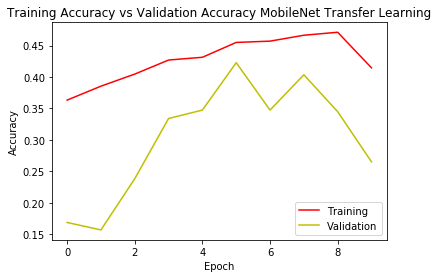

In [0]:
plt.plot(model_fitted_1.history['accuracy'], "-r", label = "Training")
plt.plot(model_fitted_1.history['val_accuracy'], "-y", label = "Validation")
plt.legend(loc = 'lower right')
plt.title('Training Accuracy vs Validation Accuracy MobileNet Transfer Learning', loc = 'center')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#Plot training accuracy vs validation accuracy

In [11]:
ResNet = tf.keras.applications.ResNet50(input_shape = (48, 48, 3), include_top = False, weights = 'imagenet')
#Load ResNet50

94773248/94765736 [==============================] - 1s 0us/step


In [12]:
model_fitted_2 = tf.keras.Sequential([
     ResNet,
     tf.keras.layers.GlobalAveragePooling2D(),
     tf.keras.layers.Dense(1024, activation = 'relu'),
     tf.keras.layers.Dense(7, activation = 'softmax')
                                      ])
model_fitted_2.summary()
#Construct model based on ResNet transfer learning

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 7175      
Total params: 25,693,063
Trainable params: 25,639,943
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
model_fitted_2.compile(optimizer = 'adam',
                       loss = 'categorical_crossentropy',
                       metrics = ['accuracy'])
#Specify loss and optimizer

In [14]:
model_fitted_resnet = model_fitted_2.fit(
   X_train_3,
   y_train,
   epochs = 5,
   batch_size = 32, 
   validation_data = (X_test_3, y_test))
#Train model with 5 epochs and batch size 32

Train on 28709 samples, validate on 7178 samples
Epoch 1/5
28709/28709 [==============================] - 4632s 161ms/sample - loss: 1.4482 - accuracy: 0.4518 - val_loss: 1.3367 - val_accuracy: 0.4858
Epoch 2/5
28709/28709 [==============================] - 4591s 160ms/sample - loss: 1.2187 - accuracy: 0.5444 - val_loss: 1.4709 - val_accuracy: 0.4694
Epoch 3/5
28709/28709 [==============================] - 4710s 164ms/sample - loss: 1.1310 - accuracy: 0.5755 - val_loss: 1.2533 - val_accuracy: 0.5217
Epoch 4/5
28709/28709 [==============================] - 4619s 161ms/sample - loss: 1.0962 - accuracy: 0.5922 - val_loss: 1.5208 - val_accuracy: 0.4650
Epoch 5/5
28709/28709 [==============================] - 4628s 161ms/sample - loss: 0.9863 - accuracy: 0.6331 - val_loss: 1.3661 - val_accuracy: 0.4760


Text(0, 0.5, 'Accuracy')

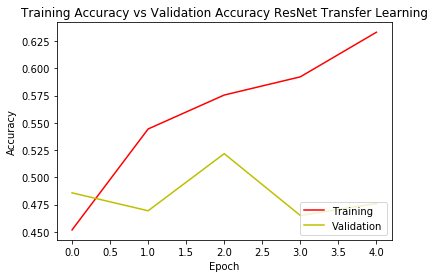

In [16]:
plt.plot(model_fitted_resnet.history['accuracy'], "-r", label = "Training")
plt.plot(model_fitted_resnet.history['val_accuracy'], "-y", label = "Validation")
plt.legend(loc = 'lower right')
plt.title('Training Accuracy vs Validation Accuracy ResNet Transfer Learning', loc = 'center')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#Plot training accuracy vs validation accuracy

In [17]:
from tensorflow.keras.applications import VGG19
vgg19 = VGG19()
#Load VGG19

574717952/574710816 [==============================] - 8s 0us/step


In [18]:
image_size = 48
image_channel = 1
input_shape = (image_size, image_size, image_channel)

vgg_transfer = tf.keras.Sequential([
     tf.keras.layers.Conv2D(32, kernel_size = (3, 3), padding = 'same', 
     activation = 'relu', input_shape = input_shape, name = 'conv_1'),
     tf.keras.layers.Conv2D(32, kernel_size = (3, 3), padding = 'same', 
     activation = 'relu', input_shape = input_shape, name = 'conv_12'),   
     tf.keras.layers.MaxPooling2D(pool_size = (2, 2), name = 'pooling_1'),
     tf.keras.layers.Dropout(0.5),
     tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = 'same', 
     activation = 'relu', name = 'conv_2'),
     tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = 'valid', 
     activation = 'relu', name = 'conv_3'),     
     tf.keras.layers.MaxPooling2D(pool_size = (2, 2), name = 'pooling_2'),
     tf.keras.layers.Dropout(0.5),
     tf.keras.layers.Conv2D(96, kernel_size = (3, 3), padding = 'same', 
     activation = 'relu', name = 'conv_4'),
     tf.keras.layers.Conv2D(96, kernel_size = (3, 3), padding = 'valid', 
     activation = 'relu', name = 'conv_5'),
     tf.keras.layers.MaxPooling2D(pool_size = (2, 2), name = 'pooling_3'),
     tf.keras.layers.Dropout(0.5),
     tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = 'same', 
     activation = 'relu', name = 'conv_6'), 
     tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = 'same', 
     activation = 'relu', name = 'conv_7'), 
     tf.keras.layers.MaxPooling2D(pool_size = (2, 2), name = 'pooling_4'),

     tf.keras.layers.Dropout(0.5),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation = 'relu', name = 'fully_connected_1'),
     tf.keras.layers.Dense(7, activation = 'softmax', name = 'fully_connected_2')
                                      ])
vgg_transfer.summary()
#Construct model based on VGG19 transfer learning

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv_12 (Conv2D)             (None, 48, 48, 32)        9248      
_________________________________________________________________
pooling_1 (MaxPooling2D)     (None, 24, 24, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 24, 24, 64)        18496     
_________________________________________________________________
conv_3 (Conv2D)              (None, 22, 22, 64)        36928     
_________________________________________________________________
pooling_2 (MaxPooling2D)     (None, 11, 11, 64)       

In [23]:
batch_size = 32
epochs = 10

vgg_transfer.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics = ['accuracy'])
history = vgg_transfer.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(X_test, y_test))
#Specify loss and optimizer and train the model with 10 epochs and batch size 32

Train on 28709 samples, validate on 7178 samples
Epoch 1/10
28709/28709 [==============================] - 455s 16ms/sample - loss: 1.8721 - accuracy: 0.2492 - val_loss: 1.8154 - val_accuracy: 0.2441
Epoch 2/10
28709/28709 [==============================] - 458s 16ms/sample - loss: 1.7874 - accuracy: 0.2606 - val_loss: 1.7796 - val_accuracy: 0.2583
Epoch 3/10
28709/28709 [==============================] - 455s 16ms/sample - loss: 1.7433 - accuracy: 0.2824 - val_loss: 1.7699 - val_accuracy: 0.2823
Epoch 4/10
28709/28709 [==============================] - 454s 16ms/sample - loss: 1.7169 - accuracy: 0.3019 - val_loss: 1.6977 - val_accuracy: 0.3008
Epoch 5/10
28709/28709 [==============================] - 450s 16ms/sample - loss: 1.6707 - accuracy: 0.3286 - val_loss: 1.6310 - val_accuracy: 0.3546
Epoch 6/10
28709/28709 [==============================] - 451s 16ms/sample - loss: 1.6257 - accuracy: 0.3598 - val_loss: 1.5516 - val_accuracy: 0.3951
Epoch 7/10
28709/28709 [=====================

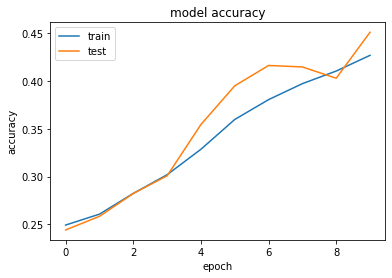

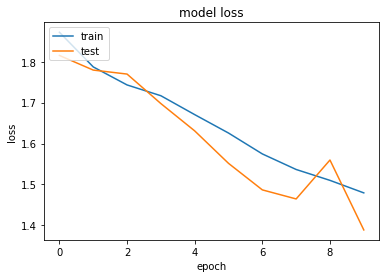

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()